# Trabajo: Eliminación de artefactos impulsivos en una imagen

En esta actividad primero realizaremos los siguientes pasos :
* la carga de imagen y librerias
* Adición de ruido
* Eliminación de ruido 
* Detección de contornos

## Introduccion, carga de imagen y librerías

shape = (512, 512)


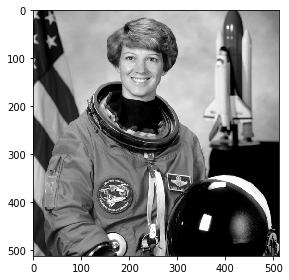

In [63]:
# Librerías
from skimage import data
from skimage import io
from skimage.transform import resize
from skimage import color
from math import log
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np

# Cargamos la imagen
myim =  data.astronaut()

# La imagen tiene 3 canales asi que hacemos un cambio a gris
im = color.rgb2gray(myim)
imcp = im.copy()
print('shape = {}'.format(im.shape))
io.imshow(im)

## Adicion de artefactos impulsivos

Para la adición de artefactos impulsivos hemos realizados los siguientes procedimientos. 
* generamos una posicion en la imagen aleatoria -> (xr,yr) aleatoria
* generamos un valor de pixel aleatorio
* asignamos a la imagen en la posicion aleatoria el valor generado -> gen_noise(M,N)
* repetimos el proceso para hasta que completemos el porcentaje especificado -> add_noise_loop(im,per)

im -> imagen original

per -> porcentaje de ruido en %

(Adicionalmente hemos creado una función para escalar la imagen entre 0 y 255)


In [2]:
# -------- Funcion escalado de imagen [0,255] -----------
def mescale(arr):
    new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
    return new_arr

# -------- Funcion de generacion de ruido -----------
def gen_noise(M,N):
    # generamos fila y columna aleatoria
    xr = np.random.randint(0,N-1)
    yr = np.random.randint(0,M-1)
    # generamos valor aleatorio
    pixval = 255*np.random.randint(2)
    # retornamos el valor
    return(xr,yr,pixval)

# -------- Funcion de iteracion segun porcentaje -----------
# (esta funcion incluye a gen_noise(M,N):)
def add_noise_loop(im,per):
    # obtenemos el rango de la imagen
    M,N = im.shape
    # hacemos una copia
    imc = im.copy()
    #numero de pixeles con ruido = porcentaje * pix totales
    np_SP  = int(np.rint(per*N*M))
    # iteramos y vamos añadiendo ruido
    for i in range(0,np_SP):
        x,y,val = gen_noise(M,N)
        imc[x,y] = val
    return imc

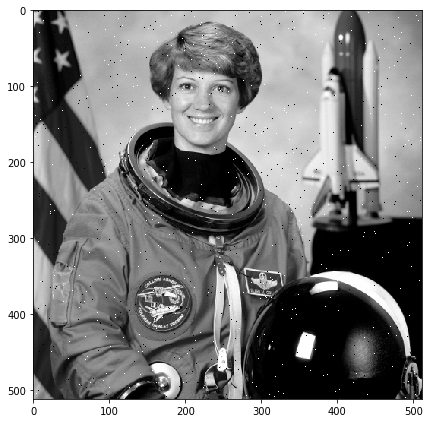

In [4]:
# escalamos la imagen [0,255]
im = mescale(im)

# añadimos ruido del 0.5% a la imagen
imc = add_noise_loop(im,0.005)

# mostramos la imagen
plt.figure(1,figsize=(6,6))
io.imshow(imc)

Vemos como hemos introducido el ruido de sal y pimienta en la imagen satisfactoriamente

## Filtrado de la imagen

Vamos a implementar primero un filtros manualmente y luego filtros de librerías.
Elegiremos posteriormente el mejor resultado

In [113]:
# -------- Funcion de que realiza filtro de media -----------
def mimean_filter(im,ns):
    M,N = im.shape
    # hacemos una copia
    m = im.copy()
    # tamaño de vecindad entre 2
    n = ns // 2
    # recorremos toda la imagen menos los bordes (truncamos)
    for j in range(n,M-n):
        for i in range(n,N-n):
            # definimos la vencindad
            local =  im[(j-n):(j+n+1),(i-n):(i+n+1)] 
            # remplazamos el pixel en cuestion por la media de la vecindad
            m[j,i]= local.mean()
    return m

# -------- Funcion de que realiza filtro de moda -----------
def mimode_filter(im,ns):
    M,N = im.shape
    # hacemos una copia
    m = im.copy()
    # tamaño de vecindad entre 2
    n = ns // 2
    # recorremos toda la imagen menos los bordes (truncamos)
    for j in range(n,M-n):
        for i in range(n,N-n):
            # definimos la vencindad
            local =  im[(j-n):(j+n+1),(i-n):(i+n+1)] 
            # remplazamos el pixel en cuestion por la moda de la vecindad
            num,times = stats.mode(local, axis=None)
            m[j,i] = int(num)    
    return m

# -------- Funcion de que realiza filtro de mediana -----------
def mimedian_filter(im,ns):
    M,N = im.shape
    # hacemos una copia
    m = im.copy()
    # tamaño de vecindad entre 2
    n = ns // 2
    # recorremos toda la imagen menos los bordes (truncamos)
    for j in range(n,M-n):
        for i in range(n,N-n):
            # definimos la vencindad
            local =  im[(j-n):(j+n+1),(i-n):(i+n+1)] 
            # remplazamos el pixel en cuestion por la mediana de la vecindad
            m[j,i]= int(np.median(local, axis=None))   
    return m

In [56]:
# Realizamos el filtro de media
imf1 = mimean_filter(imc,5)
# Realizamos el filtro de moda
imf2 = mimode_filter(imc,5) 
# Realizamos el filtro de mediana
imf3 = mimedian_filter(imc,5) 

# realizamos otros filtros

# media morfologica
from skimage.morphology import disk
from skimage.filters import rank
r = 4
strel = disk(r)
imf4 = rank.mean(imc, selem=strel)

#gaussiano
from skimage import filters
imf5 = filters.gaussian(imc, sigma=1)

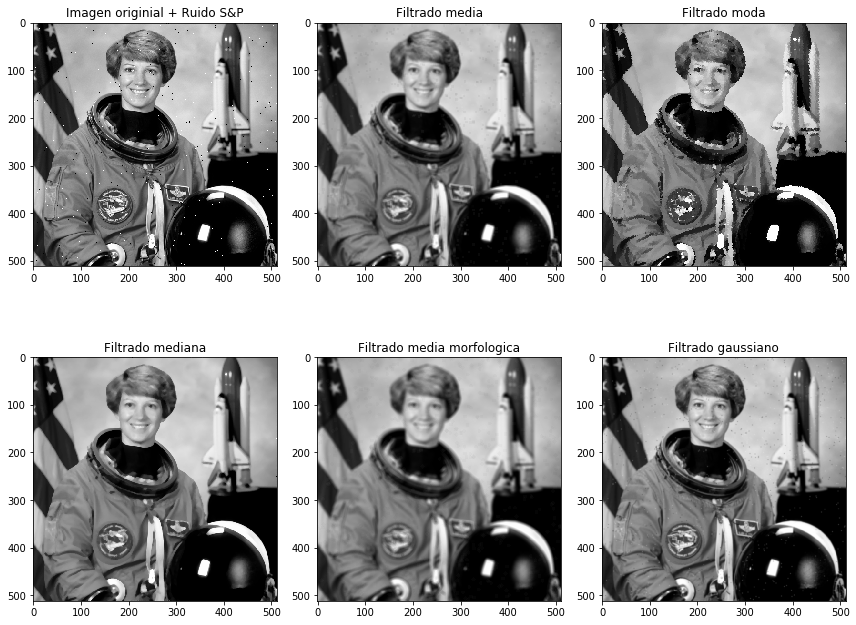

In [59]:
#vector de imagenes
image = [imc,imf1,imf2,imf3,imf4,imf5]

# vector de strings
s1 = 'Imagen originial + Ruido S&P'
s2 = 'Filtrado media'
s3 = 'Filtrado moda'
s4 = 'Filtrado mediana'
s5 = 'Filtrado media morfologica'
s6 = 'Filtrado gaussiano'

tit = [s1,s2,s3,s4,s5,s6]

# representamos las imagenes
tam = 12
fig=plt.figure(figsize=(tam, tam))
columns = 3
rows = 2

# iteramos
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(tit[i-1])
    io.imshow(image[i-1])

# mostramos    
plt.show()



Vemos como el filtro de mediana es el que nos ofrece mejores resultados

El filtro gaussiano, se acerca pero tendríamos que ajustar mas los parámetros

## Identificación de siluetas

Hemos intentado diferentes técnicas:
* Logaritmos
* Resta de imágenes (filtro paso alto)
* Gradiente de la imagen

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


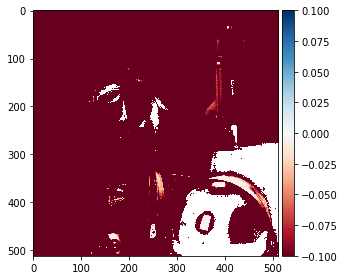

In [67]:
# 1 - intentamos con logaritmos
io.imshow(np.log(imcp))

Resultado no satisfactorio ya que no estamos teniendo en cuenta los bordes solo la intensidad
Hay que usar otros métodos por ejemplo un filtro paso alto o hacer el gradiente de la imagen

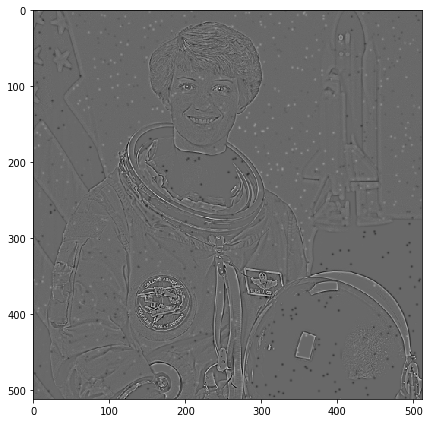

In [96]:
# 2 - Paso alto
# aprovechamos que tenemos el paso bajo
imal = im - imf5

# representamos
plt.figure(1,figsize=(6,6))
io.imshow(mescale(imal))

El resultado es satisfactorio, aunque se puede mejorar

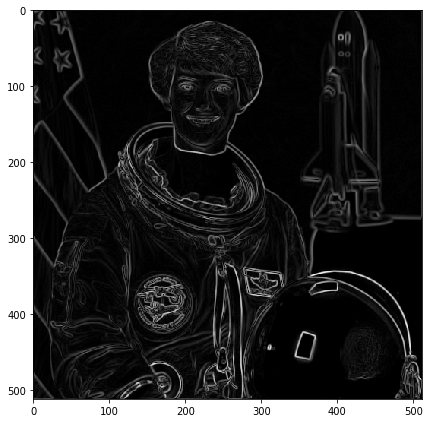

In [95]:
# Calculamos el gradiente de la imagen
px = np.array([[-1,-1,-1],[0,0,0],[1,1,1]]) #gradiente
py = px.T

M,N = im.shape
# hacemos una copia
mx = im.copy()
my = im.copy()

# tamaño de vecindad
n = 1
# recorremos toda la imagen menos los bordes (truncamos)
for j in range(n,M-n):
    for i in range(n,N-n):
        # definimos la vencindad
        local =  im[(j-n):(j+n+1),(i-n):(i+n+1)] 
        # remplazamos el pixel en cuestion por el gradiente
        mx[j,i]=  np.sum(px*local)
        my[j,i]=  np.sum(py*local)

# valor absoluto y raiz
mabs =  mx*mx + my*my
imgrad = np.sqrt(mabs)  

# representamos
plt.figure(1,figsize=(6,6))
io.imshow(mescale(imgrad)) #con escalado 

en este caso el resultado es bastante satisfactorio ya que hemos usado una herramienta mas potente
lo ultimo que quedaría seria hacer una separación por histograma

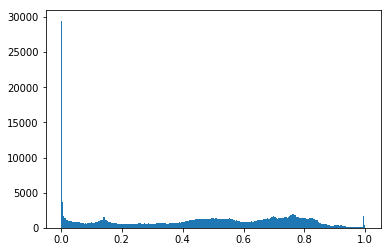

In [99]:
# Display the histogram.
plt.hist(im.ravel(), lw=0, bins=256)
plt.show()

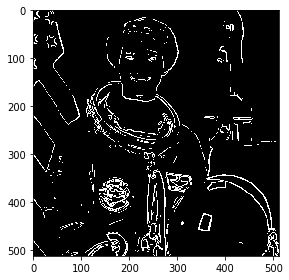

In [114]:
# Vemos como cerca de uno estan los bordes acumulados
imgrad_t = imgrad > 0.7
io.imshow(imgrad_t)

Ya tenemos los bordes adecuados clasificados como borde (true) o fondo (false)